<a href="https://colab.research.google.com/github/simjeongho/AIproject/blob/main/RandomForestIncheon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RANDOM FOREST

In [1]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt # 시각화 도구
import seaborn as sns

In [2]:
file_name = '/AllData.xlsx'
df = pd.read_excel(file_name)
display(df)

,시군구,읍면동,번지,본번,부번,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,대규모 점포,근린 공원,반려동물 등록수,병원,학교,station,starbucks
0,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,114.86,202105,3,"21,500",4,2001,갑룡길 35,0,0,1245,21,15,0,1
1,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,84.89,202107,29,"21,200",12,2001,갑룡길 35,0,0,1245,21,15,0,1
2,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,59.99,202108,27,"10,000",6,2001,갑룡길 35,0,0,1245,21,15,0,1
3,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,59.99,202108,27,"10,000",6,2001,갑룡길 35,0,0,1245,21,15,0,1
4,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,114.86,202109,19,"22,500",2,2001,갑룡길 35,0,0,1245,21,15,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24449,인천광역시 중구 항동7가,항동,91-2,91,2,53.66,202111,26,"34,000",5,1983,축항대로 234,0,0,504,8,2,0,0
24450,인천광역시 중구 항동7가,항동,91-2,91,2,53.66,202111,26,"34,000",5,1983,축항대로 234,0,0,504,8,2,0,0
24451,인천광역시 중구 항동7가,항동,91-2,91,2,53.66,202112,8,"32,000",3,1983,축항대로 234,0,0,504,8,2,0,0
24452,인천광역시 중구 항동7가,항동,91-2,91,2,53.66,202112,9,"34,000",5,1983,축항대로 234,0,0,504,8,2,0,0


In [3]:
print(df['거래금액(만원)']) # 우리가 타겟 값으로 지정할 거래금액 (정답지)
df.info()

0                21,500
1                21,200
2                10,000
3                10,000
4                22,500
              ...      
24449            34,000
24450            34,000
24451            32,000
24452            34,000
24453            32,600
Name: 거래금액(만원), Length: 24454, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24454 entries, 0 to 24453
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시군구        24454 non-null  object 
 1   읍면동        24454 non-null  object 
 2   번지         24454 non-null  object 
 3   본번         24454 non-null  int64  
 4   부번         24454 non-null  int64  
 5   전용면적(㎡)    24454 non-null  float64
 6   계약년월       24454 non-null  int64  
 7   계약일        24454 non-null  int64  
 8   거래금액(만원)   24454 non-null  object 
 9   층          24454 non-null  int64  
 10  건축년도       24454 non-null  int64  
 11  도로명        24454 non-null  object 
 12  대규모 점포     24454 

정규 표현식을 이용해 날짜 형식 확인

In [4]:
import re
def regex(data):
    pattern = re.compile('^[0-9]{6}')
    match = pattern.match(data)
    if match:
        return True
    else:
        return False
date_pattern_check_series = df['계약년월'].apply(lambda data: regex(str(data)))
print(all(date_pattern_check_series))
del date_pattern_check_series

True


데이터 자료형 모두 float32형으로 변경해줌

In [5]:
df_copy = df.copy();
drop_list = ['번지','본번','부번','계약일','도로명']
for i in drop_list:
  df_copy = df_copy.drop(i, axis= 1) # 필요 없는 특성은 df에서 제거해준다. 
df_copy['거래금액(만원)'] = df_copy['거래금액(만원)'].str.replace(',','')
df_copy.rename(columns={'전용면적(㎡)':'전용면적', '거래금액(만원)': '거래금액'}, inplace=True) # 이름 재정의 
df_copy['시군구'] = df_copy['시군구'].astype('category').cat.rename_categories({string : i for i,string in enumerate(df_copy['시군구'].unique())})
df_copy['읍면동'] = df_copy['읍면동'].astype('category').cat.rename_categories({string : i for i,string in enumerate(df_copy['읍면동'].unique())})
df_copy['전용면적'] = df_copy['전용면적'].astype('float32')
df_copy['계약년월'] = df_copy['계약년월'].astype('float32')
df_copy['거래금액'] = df_copy['거래금액'].astype('float32')
df_copy['층'] = df_copy['층'].astype('float32')
df_copy['건축년도'] = df_copy['건축년도'].astype('float32')
df_copy['대규모 점포'] = df_copy['대규모 점포'].astype('float32')
df_copy['근린 공원'] = df_copy['근린 공원'].astype('float32')
df_copy['반려동물 등록수'] = df_copy['반려동물 등록수'].astype('float32')
df_copy['병원'] = df_copy['병원'].astype('float32')
df_copy['학교'] = df_copy['학교'].astype('float32')
df_copy['station'] = df_copy['station'].astype('float32')
df_copy['starbucks'] = df_copy['starbucks'].astype('float32')
df_copy.head()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24454 entries, 0 to 24453
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   시군구        24454 non-null  category
 1   읍면동        24454 non-null  category
 2   전용면적       24454 non-null  float32 
 3   계약년월       24454 non-null  float32 
 4   거래금액       24454 non-null  float32 
 5   층          24454 non-null  float32 
 6   건축년도       24454 non-null  float32 
 7   대규모 점포     24454 non-null  float32 
 8   근린 공원      24454 non-null  float32 
 9   반려동물 등록수   24454 non-null  float32 
 10  병원         24454 non-null  float32 
 11  학교         24454 non-null  float32 
 12  station    24454 non-null  float32 
 13  starbucks  24454 non-null  float32 
dtypes: category(2), float32(12)
memory usage: 1.2 MB


데이터의 각 범주별로 범위가 다르므로 minmaxScaler를 통해 모든 데이터를 0 ~ 1사이의 값으로 변경해준다.

In [6]:
df_copy['계약년월'] = df_copy['계약년월'].astype('float32')
df_copy_make = df_copy.filter(['전용면적', '계약년월', '거래금액', '층','건축년도','대규모 점포','근린 공원','반려동물 등록수', '병원','학교','station','starbucks'])
df_copy_make.info()
X = df_copy_make.drop('거래금액', axis=1).to_numpy() #데이터 프레임에서 타겟값(거래금액(만원))을 제외하고 넘파이 배열로 만들어준다.
Y = df_copy_make['거래금액'].to_numpy().reshape((-1,1)) # 데이터 프레임 형태의 타겟 값을 넘파이 배열로 만들어준다.
#데이터 스케일링
#sklearn에서 제공하는 MinMaxScaler
#(X- min(X)) / (max(X)-min(X))을 계산 
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24454 entries, 0 to 24453
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   전용면적       24454 non-null  float32
 1   계약년월       24454 non-null  float32
 2   거래금액       24454 non-null  float32
 3   층          24454 non-null  float32
 4   건축년도       24454 non-null  float32
 5   대규모 점포     24454 non-null  float32
 6   근린 공원      24454 non-null  float32
 7   반려동물 등록수   24454 non-null  float32
 8   병원         24454 non-null  float32
 9   학교         24454 non-null  float32
 10  station    24454 non-null  float32
 11  starbucks  24454 non-null  float32
dtypes: float32(12)
memory usage: 1.1 MB


In [24]:
# 각 변수들의 상관계수 파악 
df_copy_english = df_copy.copy()
df_copy_english.rename(columns={'전용면적':'area', '읍면동': 'town', '거래금액': 'price', '시군구' : 'city', '계약년월' : 'contractyear', '층': 'floor', '건축년도': 'yoConstruct', '대규모 점포': 'bigmarket', '근린 공원': 'park', '반려동물 등록수':'pet', '병원': 'hospital', '학교': 'school'}, inplace=True)
df_copy_english.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24454 entries, 0 to 24453
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city          24454 non-null  category
 1   town          24454 non-null  category
 2   area          24454 non-null  float32 
 3   contractyear  24454 non-null  float32 
 4   price         24454 non-null  float32 
 5   floor         24454 non-null  float32 
 6   yoConstruct   24454 non-null  float32 
 7   bigmarket     24454 non-null  float32 
 8   park          24454 non-null  float32 
 9   pet           24454 non-null  float32 
 10  hospital      24454 non-null  float32 
 11  school        24454 non-null  float32 
 12  station       24454 non-null  float32 
 13  starbucks     24454 non-null  float32 
dtypes: category(2), float32(12)
memory usage: 1.2 MB


big market과 school사이의 상관계수가 0.69
hospital과 pet사이의 상관계수가 0.9 
big market과 hospital사이의 상관계수가 0.66
big market과 pet사이의 상관계수가 0.62
school과 hospital 사이의 상관계수가 0.63
상식적으로 연관이 있는 데이터끼리 상관계수가 높게 나왔으므로 유의미한 데이터라고 판단할 수 있음 하지만 너무 상관계수가 높은 데이터들끼리만 치우쳐져 있을 경우 overfitting과 같은 문제가 발생할 수 있다. 


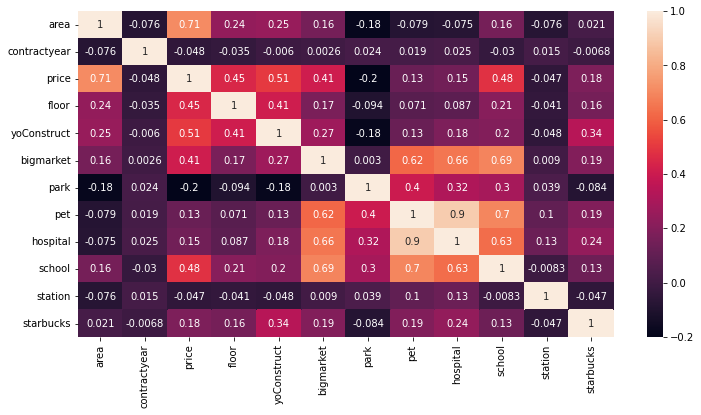

In [25]:
#상관계수 분석 
plt.figure(figsize=(12,6))
sns.heatmap(df_copy_english.select_dtypes(np.number).corr(),annot=True)
plt.show()

In [26]:
#데이터를 텐셔 형태로 변환해주는 클래스 
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)# Double Tensor는 Float64로 변환 Float Tensor는 Float32로 변환 
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index) :
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

In [27]:
#scikit-learn 을 이용해서 학습 데이터와 평가 데이터로 나눈다. 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.5) # hyper parameter 테스트 사이즈
# train데이터와 validation 데이터로 나눈다. 
X2_train, X_val, Y2_train, Y_val = train_test_split(X_train, Y_train)
#학습 데이터랑 시험데이터를 배치 형태로 구축한다.
print(X2_train.shape)
print(X2_train.ndim)
print(X_val.shape)
print(Y2_train.shape)
print(Y2_train.ndim)
print(Y_val.shape)
trainsets = TensorData(X2_train, Y2_train)
trainLoader = torch.utils.data.DataLoader(trainsets, batch_size = 32, shuffle=True) # 하이퍼 파라미터 배치 사이즈 

validationsets = TensorData(X_val, Y_val) #validation set
validationLoader = torch.utils.data.DataLoader(validationsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test) # 테스트 데이터들을 나눠준다. 
testloader = torch.utils.data.DataLoader(testsets, batch_size = 32, shuffle=True) 

(9170, 11)
2
(3057, 11)
(9170, 1)
2
(3057, 1)


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
estimator = RandomForestRegressor(n_estimators=500, 
                                  bootstrap=True, criterion='mse', 
                                  max_depth=None, max_leaf_nodes=None, 
                                  min_samples_split=2, min_samples_leaf=1, 
                                  max_features='auto') # 랜덤 포레스트는 각 트리를 거친 후의 모든 트리의 평균값으로 값을 냄
estimator.fit(X2_train, Y2_train) # 학습 진행
print(estimator.score(X2_train, Y2_train))
print(estimator.score(X_val, Y_val))
print(estimator.score(X_test, Y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


0.9915999503709513
0.9473639591340367
0.9411936298989252
